In [1]:
import warnings
from matplotlib.ticker import MultipleLocator
import string
from prettytable import PrettyTable
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
import re
import os
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import ast

In [2]:
df = pd.read_csv("../input/multilabelsongs/MultiLabelSongs_EN.csv")
df.head(2)

,artist,genre,title,album,lyrics,labels
0,Nirvana,Rock,You Know You’re Right,Nirvana,I will never bother you\nI will never promise ...,"Calmness, Sadness"
1,Damian Marley,Reggae,Here We Go,Stony Hill,Here we go\nMy big ego is gonna get me in trou...,"Power, Tension"


In [3]:
df['labels'] = df['labels'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
df['labels'] = df['labels'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
df.head(2)

,artist,genre,title,album,lyrics,labels
0,Nirvana,Rock,You Know You’re Right,Nirvana,I will never bother you\nI will never promise ...,"Calmness, Sadness"
1,Damian Marley,Reggae,Here We Go,Stony Hill,Here we go\nMy big ego is gonna get me in trou...,"Power, Tension"


In [4]:
df['labels'] = df['labels'].str.split(',\s*')
df.head(2)

,artist,genre,title,album,lyrics,labels
0,Nirvana,Rock,You Know You’re Right,Nirvana,I will never bother you\nI will never promise ...,"[Calmness, Sadness]"
1,Damian Marley,Reggae,Here We Go,Stony Hill,Here we go\nMy big ego is gonna get me in trou...,"[Power, Tension]"


In [5]:
all_emotions = sorted(list(set([e for labels in df['labels'] for e in labels])))
mlb = MultiLabelBinarizer(classes=all_emotions)
labels_bin = mlb.fit_transform(df['labels'])

for i, label in enumerate(mlb.classes_):
    print(f"{i}: {label}")

0: Amazement
1: Calmness
2: Joyful activation
3: Nostalgia
4: Power
5: Sadness
6: Solemnity
7: Tenderness
8: Tension


In [6]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['lyrics'].tolist(), labels_bin, test_size=0.2, random_state=42
)

In [7]:
def evaluate(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            logits = model(input_ids, attention_mask)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    f1_micro = f1_score(all_labels, all_preds, average='micro')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=all_emotions, zero_division=0)
    return f1_micro, f1_macro, precision, recall, acc, report, all_labels, all_preds

In [8]:
def plot_confusion_per_class(true_labels, pred_labels, class_names, epoch=None):
    for i, class_name in enumerate(class_names):
        cm = confusion_matrix(true_labels[:, i], pred_labels[:, i])
        plt.figure(figsize=(3.5, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Not ' + class_name, class_name],
                    yticklabels=['Not ' + class_name, class_name])
        plt.xlabel("Predicted")
        plt.ylabel("True")
        title = f"Confusion Matrix: {class_name}"
        if epoch is not None:
            title += f" (Epoch {epoch+1})"
        plt.title(title)
        plt.tight_layout()
        plt.show()

In [9]:
class LyricsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        labels = self.labels[idx]
        encoding = self.tokenizer(text,
                                  max_length=self.max_len,
                                  padding='max_length',
                                  truncation=True,
                                  return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.FloatTensor(labels)
        }

class MultiLabelClassificationModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.model.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # [CLS] token
        dropped = self.dropout(pooled_output)
        logits = self.classifier(dropped)
        return logits 

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = "xlm-roberta-base"
#model_name = "readerbench/RoBERT-base"
#model_name = "racai/distilbert-base-romanian-cased"
#model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = MultiLabelClassificationModel(model_name, num_labels=len(all_emotions))
model.to(device)

train_dataset = LyricsDataset(train_texts, train_labels, tokenizer)
val_dataset = LyricsDataset(val_texts, val_labels, tokenizer)
train_dataset = LyricsDataset(train_texts, train_labels, tokenizer)
val_dataset = LyricsDataset(val_texts, val_labels, tokenizer)

idx = 0
sample = train_dataset[idx]
original_text = train_texts[idx]
print("=== Text original ===")
print(original_text)
print("\n=== Token IDs ===")
print(sample['input_ids'])
print("\n=== Attention Mask ===")
print(sample['attention_mask'])
print("\n=== Tokens ===")
print(tokenizer.convert_ids_to_tokens(sample['input_ids']))
print("\n=== Label ===")
print(sample['labels'])
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

2025-06-02 20:13:22.558963: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748895202.582469     126 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748895202.589364     126 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


=== Text original ===
Picture all the possibilities
Picture all the possibilities
Sounds like a love song
Sounds like a love song
The most incredible, baby
I can't see 'em comin' down my eyes
So I gotta make the song cry
I can't see 'em comin' down my eyes
So I gotta make the song cry

Good dude, I know you love me like cooked food
Even though a nigga gotta move like a crook move
We was together on the block since free lunch
We shoulda been together havin' Four Seasons brunch
We used to use umbrellas to face the bad weather
So now we travel first class to change the forecast
Never in bunches, just me and you
I loved your point of view ‘cause you held no punches
Still I left you for months on end
It's been months since I checked back in
We're somewhere in a small town
Somewhere lockin' a mall down
Woodgrain, four and change, Armor All'd down
I can understand why you want a divorce now
Though I can't let you know it, pride won't let me show it
Pretend to be heroic, that's just one to gro

In [11]:
for param in model.model.embeddings.parameters():
    param.requires_grad = True

# Freeze primele 2 layere in encoder
#for name, param in model.model.encoder.named_parameters():
#    if "layer." in name:
#        layer_num = int(name.split('.')[1])
#        if layer_num < 2:
#            param.requires_grad = False

# Calculez pos_weight pe baza distribuției claselor în train_labels
if not isinstance(train_labels, torch.Tensor):
    train_labels_tensor = torch.tensor(train_labels)
else:
    train_labels_tensor = train_labels

pos_counts = train_labels_tensor.sum(dim=0)
neg_counts = train_labels_tensor.shape[0] - pos_counts
pos_weight = neg_counts / pos_counts
print("Pos weight per class:", pos_weight)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
#criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5, weight_decay=1e-2)

Pos weight per class: tensor([4.1034, 3.8000, 2.4154, 1.6350, 1.5517, 0.9603, 2.1601, 1.3617, 1.0993])


In [12]:
train_losses = []
train_f1micros, train_f1macros, val_f1micros, val_f1macros = [], [], [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_accs, val_accs = [], []

best_model_path = "checkpoint.pt"
best_score = 0
epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        if epoch == 0 and loop.n == 0:
            print("input_ids shape:", input_ids.shape)
            print("attention_mask shape:", attention_mask.shape)
            print("labels shape:", labels.shape)
            print("labels example:", labels[0])

        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_f1_micro, train_f1_macro, train_prec, train_rec, train_acc, _, _, _ = evaluate(model, train_loader)
    train_f1micros.append(train_f1_micro)
    train_f1macros.append(train_f1_macro)
    train_precisions.append(train_prec)
    train_recalls.append(train_rec)
    train_accs.append(train_acc)

    val_f1_micro, val_f1_macro, val_prec, val_rec, val_acc, _, _, _ = evaluate(model, val_loader)
    val_f1micros.append(val_f1_micro)
    val_f1macros.append(val_f1_macro)
    val_precisions.append(val_prec)
    val_recalls.append(val_rec)
    val_accs.append(val_acc)

    val_score = val_f1_micro + val_f1_macro
    if val_score > best_score:
        best_score = val_score
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_score': best_score
        }
        torch.save(checkpoint, best_model_path)
        print("Checkpoint salvat cu succes.")
        print(f"Model salvat: Epoca {epoch+1} cu scor val total: {val_score:.4f}")

    print(f"\nEpoch {epoch+1}")
    print(f"Train -> F1 macro: {train_f1_macro:.4f}, F1 micro: {train_f1_micro:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, Acc: {train_acc:.4f}, Loss: {avg_train_loss:.4f}")
    print(f" Val  -> F1 macro: {val_f1_macro:.4f}, F1 micro: {val_f1_micro:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, Acc: {val_acc:.4f}")

Epoch 1:   0%|          | 0/56 [00:00<?, ?it/s]

input_ids shape: torch.Size([16, 512])
attention_mask shape: torch.Size([16, 512])
labels shape: torch.Size([16, 9])
labels example: tensor([0., 1., 0., 0., 0., 1., 0., 1., 1.], device='cuda:0')


Epoch 1: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.843]


Checkpoint salvat cu succes.
Model salvat: Epoca 1 cu scor val total: 0.6935

Epoch 1
Train -> F1 macro: 0.2347, F1 micro: 0.4375, Precision: 0.5186, Recall: 0.3528, Acc: 0.0045, Loss: 0.9126
 Val  -> F1 macro: 0.2438, F1 micro: 0.4497, Precision: 0.3319, Recall: 0.3539, Acc: 0.0000


Epoch 2: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.984]


Checkpoint salvat cu succes.
Model salvat: Epoca 2 cu scor val total: 0.8083

Epoch 2
Train -> F1 macro: 0.3631, F1 micro: 0.4954, Precision: 0.4474, Recall: 0.4811, Acc: 0.0135, Loss: 0.8933
 Val  -> F1 macro: 0.3197, F1 micro: 0.4886, Precision: 0.3359, Recall: 0.4482, Acc: 0.0090


Epoch 3: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.874]


Checkpoint salvat cu succes.
Model salvat: Epoca 3 cu scor val total: 1.0575

Epoch 3
Train -> F1 macro: 0.5571, F1 micro: 0.6128, Precision: 0.5983, Recall: 0.6032, Acc: 0.0586, Loss: 0.8480
 Val  -> F1 macro: 0.4790, F1 micro: 0.5785, Precision: 0.6467, Recall: 0.5340, Acc: 0.0676


Epoch 4: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.733]


Checkpoint salvat cu succes.
Model salvat: Epoca 4 cu scor val total: 1.1338

Epoch 4
Train -> F1 macro: 0.6345, F1 micro: 0.6551, Precision: 0.5998, Recall: 0.7040, Acc: 0.0755, Loss: 0.7918
 Val  -> F1 macro: 0.5507, F1 micro: 0.5832, Precision: 0.5535, Recall: 0.5868, Acc: 0.0360


Epoch 5: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.673]


Checkpoint salvat cu succes.
Model salvat: Epoca 5 cu scor val total: 1.1961

Epoch 5
Train -> F1 macro: 0.6698, F1 micro: 0.6799, Precision: 0.6215, Recall: 0.7732, Acc: 0.0968, Loss: 0.7336
 Val  -> F1 macro: 0.5855, F1 micro: 0.6106, Precision: 0.5683, Recall: 0.6501, Acc: 0.0586


Epoch 6: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.728]



Epoch 6
Train -> F1 macro: 0.7087, F1 micro: 0.7272, Precision: 0.6809, Recall: 0.7643, Acc: 0.1295, Loss: 0.6813
 Val  -> F1 macro: 0.5631, F1 micro: 0.6205, Precision: 0.6071, Recall: 0.5928, Acc: 0.1081


Epoch 7: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.627]


Checkpoint salvat cu succes.
Model salvat: Epoca 7 cu scor val total: 1.2521

Epoch 7
Train -> F1 macro: 0.7335, F1 micro: 0.7449, Precision: 0.6754, Recall: 0.8233, Acc: 0.1329, Loss: 0.6410
 Val  -> F1 macro: 0.6160, F1 micro: 0.6362, Precision: 0.5888, Recall: 0.6604, Acc: 0.0766


Epoch 8: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.449]



Epoch 8
Train -> F1 macro: 0.7588, F1 micro: 0.7674, Precision: 0.7246, Recall: 0.8157, Acc: 0.1610, Loss: 0.5996
 Val  -> F1 macro: 0.5579, F1 micro: 0.6050, Precision: 0.5832, Recall: 0.5799, Acc: 0.0811


Epoch 9: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.509]



Epoch 9
Train -> F1 macro: 0.7910, F1 micro: 0.7986, Precision: 0.7381, Recall: 0.8609, Acc: 0.2083, Loss: 0.5704
 Val  -> F1 macro: 0.5794, F1 micro: 0.6188, Precision: 0.5768, Recall: 0.5909, Acc: 0.0676


Epoch 10: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.664]



Epoch 10
Train -> F1 macro: 0.8022, F1 micro: 0.8089, Precision: 0.7468, Recall: 0.8826, Acc: 0.2218, Loss: 0.5231
 Val  -> F1 macro: 0.5879, F1 micro: 0.6147, Precision: 0.5738, Recall: 0.6200, Acc: 0.0586


Epoch 11: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.52] 



Epoch 11
Train -> F1 macro: 0.7898, F1 micro: 0.7965, Precision: 0.7388, Recall: 0.8817, Acc: 0.2083, Loss: 0.4846
 Val  -> F1 macro: 0.5807, F1 micro: 0.5944, Precision: 0.5639, Recall: 0.6273, Acc: 0.0856


Epoch 12: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.438]



Epoch 12
Train -> F1 macro: 0.8234, F1 micro: 0.8292, Precision: 0.7775, Recall: 0.8929, Acc: 0.2815, Loss: 0.4456
 Val  -> F1 macro: 0.5868, F1 micro: 0.6096, Precision: 0.5863, Recall: 0.6068, Acc: 0.0721


Epoch 13: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.304]



Epoch 13
Train -> F1 macro: 0.8672, F1 micro: 0.8639, Precision: 0.8309, Recall: 0.9149, Acc: 0.3761, Loss: 0.4220
 Val  -> F1 macro: 0.5842, F1 micro: 0.6259, Precision: 0.6049, Recall: 0.5918, Acc: 0.0991


Epoch 14: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.341]



Epoch 14
Train -> F1 macro: 0.8838, F1 micro: 0.8813, Precision: 0.8426, Recall: 0.9330, Acc: 0.4459, Loss: 0.3876
 Val  -> F1 macro: 0.5725, F1 micro: 0.6080, Precision: 0.5730, Recall: 0.5869, Acc: 0.0856


Epoch 15: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.372]



Epoch 15
Train -> F1 macro: 0.8958, F1 micro: 0.8942, Precision: 0.8676, Recall: 0.9337, Acc: 0.4887, Loss: 0.3543
 Val  -> F1 macro: 0.5774, F1 micro: 0.6023, Precision: 0.5823, Recall: 0.5815, Acc: 0.0946


Epoch 16: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.357]



Epoch 16
Train -> F1 macro: 0.9166, F1 micro: 0.9120, Precision: 0.8914, Recall: 0.9470, Acc: 0.5439, Loss: 0.3294
 Val  -> F1 macro: 0.5730, F1 micro: 0.6087, Precision: 0.5981, Recall: 0.5684, Acc: 0.0946


Epoch 17: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.288]



Epoch 17
Train -> F1 macro: 0.9272, F1 micro: 0.9220, Precision: 0.9028, Recall: 0.9563, Acc: 0.5901, Loss: 0.2984
 Val  -> F1 macro: 0.5704, F1 micro: 0.6064, Precision: 0.5749, Recall: 0.5808, Acc: 0.0811


Epoch 18: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.286]



Epoch 18
Train -> F1 macro: 0.9471, F1 micro: 0.9409, Precision: 0.9283, Recall: 0.9673, Acc: 0.6768, Loss: 0.2747
 Val  -> F1 macro: 0.5710, F1 micro: 0.6163, Precision: 0.6003, Recall: 0.5636, Acc: 0.0721


Epoch 19: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.2]  



Epoch 19
Train -> F1 macro: 0.9505, F1 micro: 0.9437, Precision: 0.9394, Recall: 0.9639, Acc: 0.6926, Loss: 0.2479
 Val  -> F1 macro: 0.5699, F1 micro: 0.6135, Precision: 0.6139, Recall: 0.5523, Acc: 0.0991


Epoch 20: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.275]



Epoch 20
Train -> F1 macro: 0.9614, F1 micro: 0.9562, Precision: 0.9487, Recall: 0.9750, Acc: 0.7635, Loss: 0.2231
 Val  -> F1 macro: 0.5504, F1 micro: 0.5945, Precision: 0.5713, Recall: 0.5568, Acc: 0.0676


In [13]:
def load_model_from_checkpoint(path, model_name, num_labels, device):
    model = MultiLabelClassificationModel(model_name, num_labels)
    checkpoint = torch.load(path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    return model, checkpoint['epoch'], checkpoint['best_score']


GENERAL PERFORMANCE AFTER TRAINING
Train:
F1 macro: 0.7335, F1 micro: 0.7449, Precision: 0.6754, Recall: 0.8233, Acc: 0.1329
                   precision    recall  f1-score   support

        Amazement       0.50      0.89      0.64       174
         Calmness       0.52      0.85      0.64       185
Joyful activation       0.68      0.91      0.78       260
        Nostalgia       0.58      0.80      0.68       337
            Power       0.79      0.76      0.78       348
          Sadness       0.85      0.83      0.84       453
        Solemnity       0.60      0.72      0.66       281
       Tenderness       0.77      0.93      0.85       376
          Tension       0.78      0.71      0.74       423

        micro avg       0.69      0.82      0.74      2837
        macro avg       0.68      0.82      0.73      2837
     weighted avg       0.71      0.82      0.75      2837
      samples avg       0.70      0.84      0.74      2837


Validation:
F1 macro: 0.6160, F1 micro: 0.63

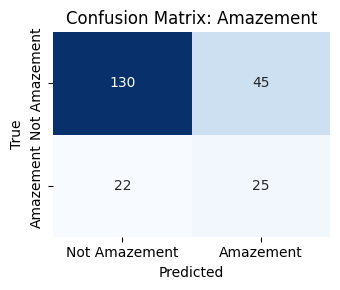

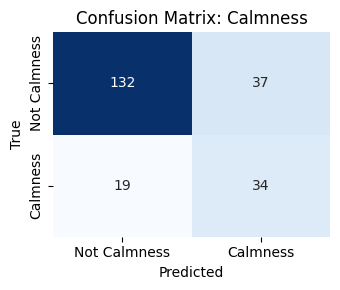

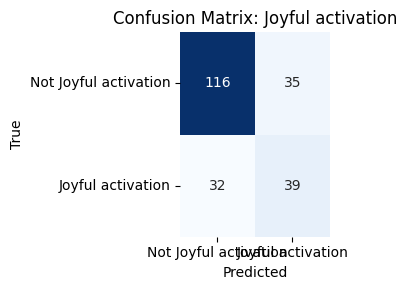

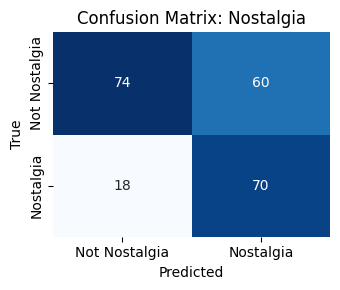

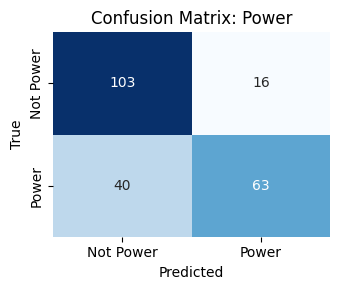

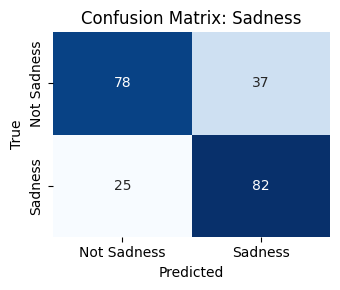

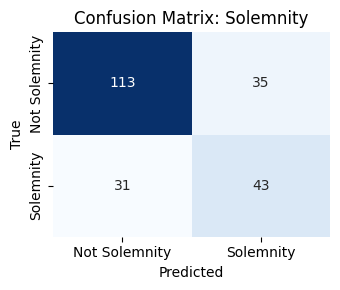

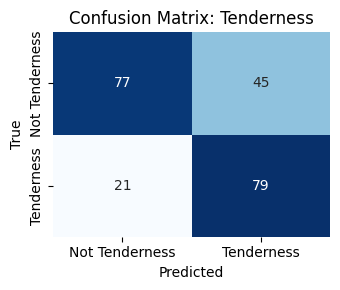

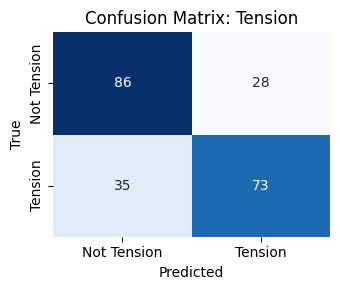

In [14]:
model_path = best_model_path

model, last_epoch, best_score = load_model_from_checkpoint(
    path=model_path,
    model_name=model_name,
    num_labels=len(all_emotions),
    device=device
)

model.eval()

train_f1_micro, train_f1_macro, train_prec, train_rec, train_acc, train_report, _, _ = evaluate(model, train_loader)
val_f1_micro, val_f1_macro, val_prec, val_rec, val_acc, val_report, val_labels, val_preds = evaluate(model, val_loader)

print("\nGENERAL PERFORMANCE AFTER TRAINING")
print("Train:")
print(f"F1 macro: {train_f1_macro:.4f}, F1 micro: {train_f1_micro:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, Acc: {train_acc:.4f}")
print(train_report)

print("\nValidation:")
print(f"F1 macro: {val_f1_macro:.4f}, F1 micro: {val_f1_micro:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, Acc: {val_acc:.4f}")
print(val_report)

plot_confusion_per_class(val_labels, val_preds, all_emotions)

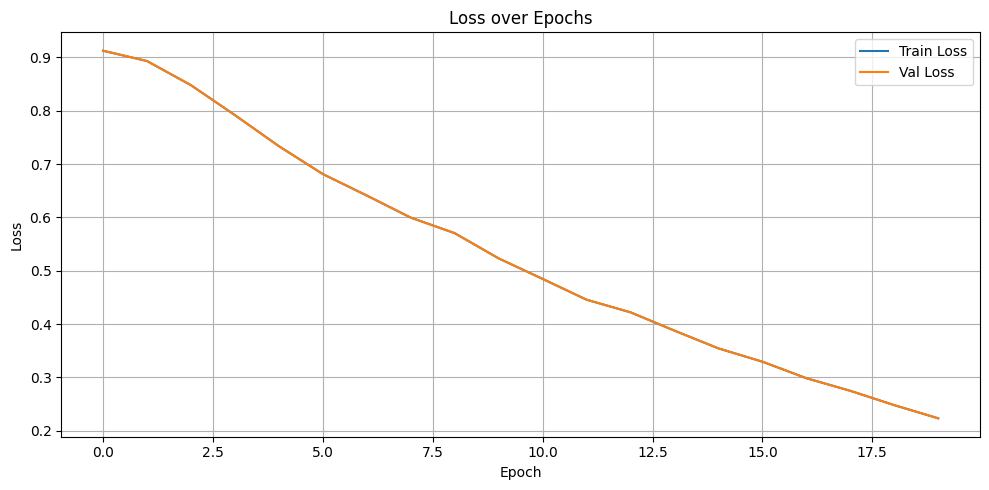

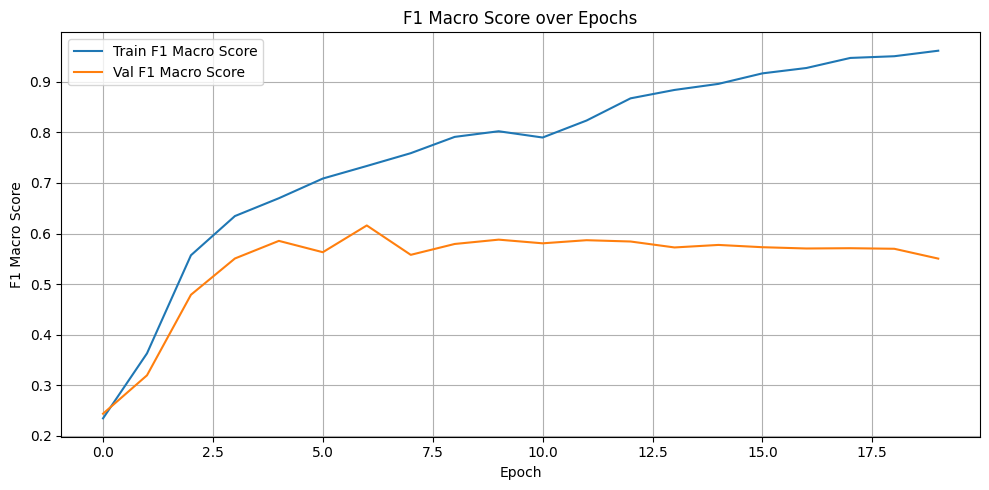

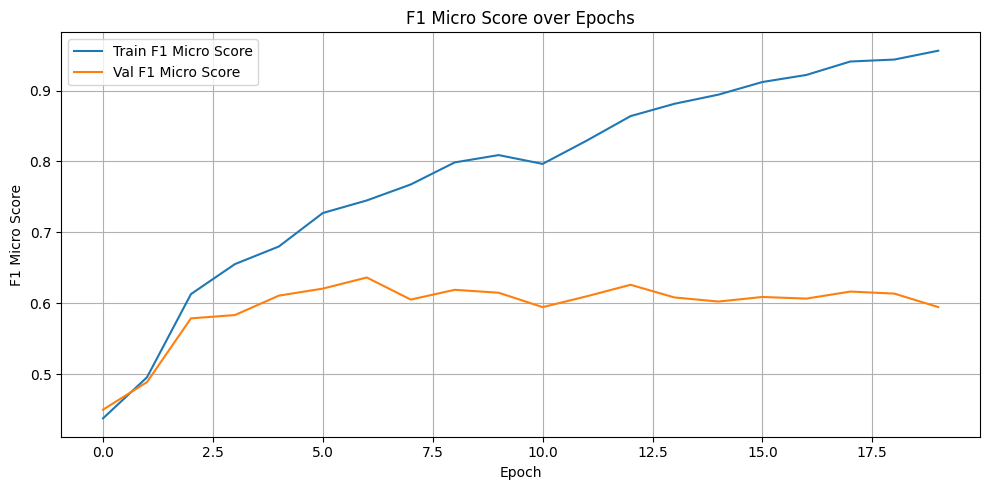

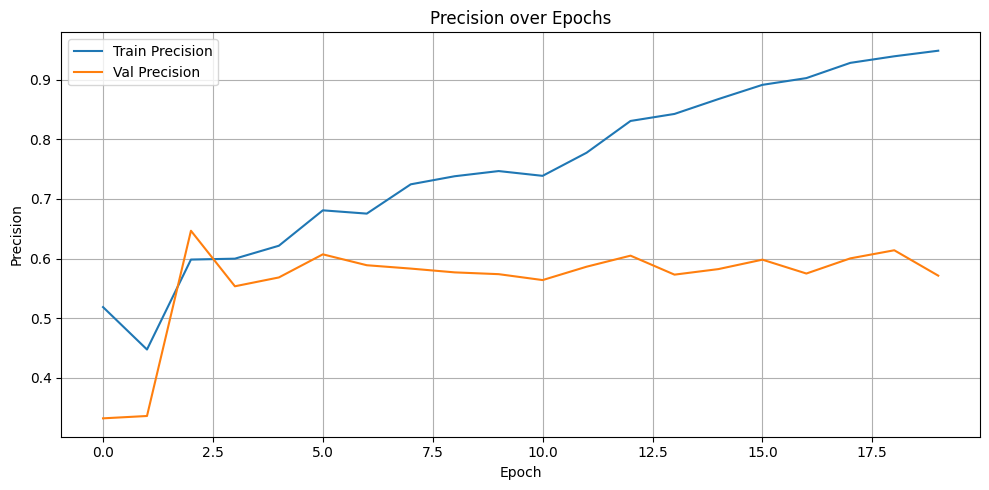

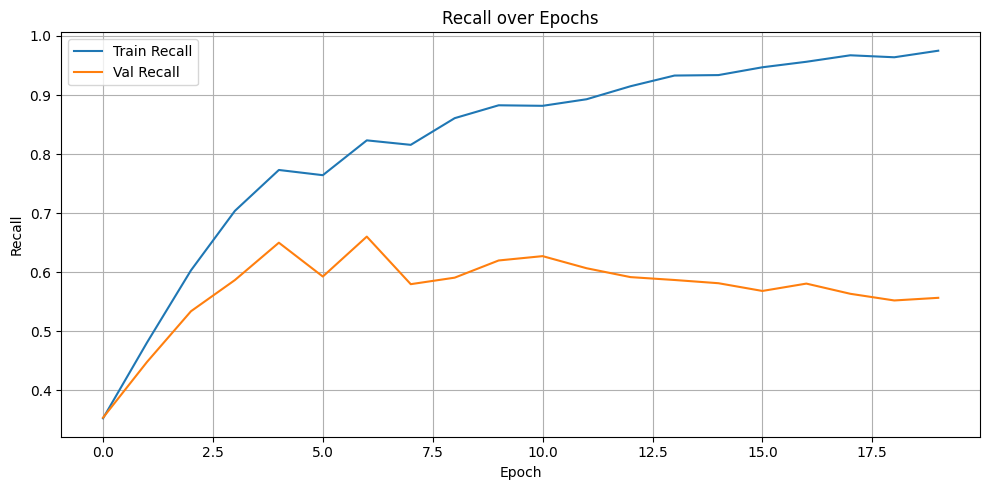

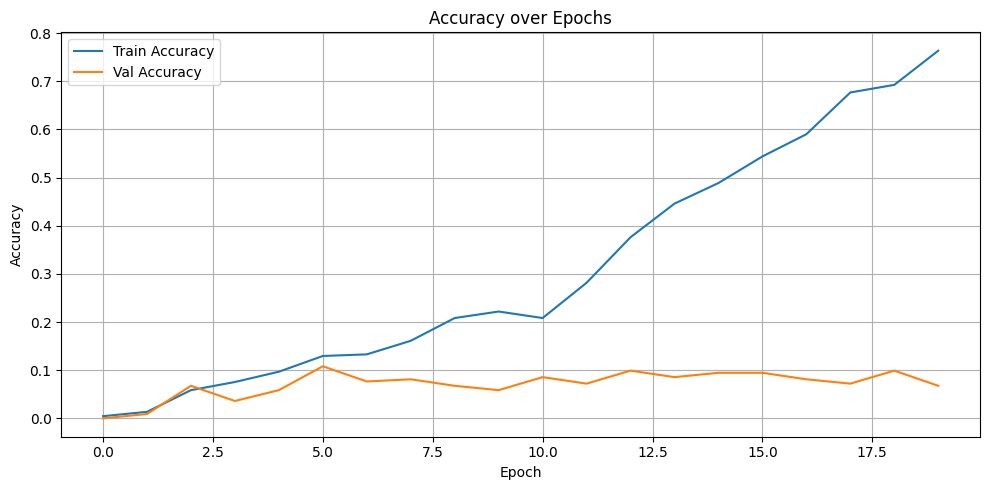

In [15]:
def plot_metrics(train, val, name):
    plt.figure(figsize=(10, 5))
    plt.plot(train, label=f'Train {name}')
    plt.plot(val, label=f'Val {name}')
    plt.xlabel("Epoch")
    plt.ylabel(name)
    plt.title(f"{name} over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{name.lower().replace(' ', '_')}_curve.png")
    plt.show()

plot_metrics(train_losses, train_losses, "Loss")
plot_metrics(train_f1macros, val_f1macros, "F1 Macro Score")
plot_metrics(train_f1micros, val_f1micros, "F1 Micro Score")
plot_metrics(train_precisions, val_precisions, "Precision")
plot_metrics(train_recalls, val_recalls, "Recall")
plot_metrics(train_accs, val_accs, "Accuracy")

In [16]:
def predict_emotions(text, model, tokenizer, threshold=0.5):
    model.eval()
    encoding = tokenizer(text,
                         max_length=512,
                         padding='max_length',
                         truncation=True,
                         return_tensors='pt')
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    preds = (probs >= threshold).astype(int)
    results = {emotion: float(prob) for emotion, prob in zip(all_emotions, probs)}
    predicted_emotions = [emotion for emotion, pred in zip(all_emotions, preds) if pred == 1]
    return predicted_emotions, results

In [17]:
text_ro = "O vreme, a fost greu în ultima vreme, am fost mai bine decât în ultimele patru decembrie reci pe care mi le amintesc. Și îmi văd familia în fiecare lună. Am găsit o fată pe care o iubesc părinții mei. Vine să stea peste noapte și cred că aș putea avea totul. Și îi mulțumesc lui Dumnezeu în fiecare zi pentru fata pe care mi-a trimis-o. Dar știu lucrurile pe care mi le dă, le poate lua. Și te țin în brațe în fiecare noapte. Și acesta e un sentiment cu care vreau să mă obișnuiesc. Dar nu există bărbat mai înspăimântat ca bărbatul care riscă să te piardă."
predicted_emotions_ro, probs_ro = predict_emotions(text_ro, model, tokenizer)
print("RO")
print("Predicted emotions:", predicted_emotions_ro)
print("Probabilities per emotion:", probs_ro)

text_en = "For a while, it's been hard lately, I've been better than I've been in the last four cold Decembers that I can remember. And I see my family every month. I found a girl that my parents love. She's coming to stay overnight and I think I could have it all. And I thank God every day for the girl he sent me. But I know the things he gives me, he can take away. And I hold you in my arms every night. And that's a feeling I want to get used to. But there's no man more scared than the man who risks losing you."
predicted_emotions_en, probs_en = predict_emotions(text_en, model, tokenizer)
print("EN")
print("Predicted emotions:", predicted_emotions_en)
print("Probabilities per emotion:", probs_en)

RO
Predicted emotions: ['Nostalgia', 'Sadness', 'Tenderness']
Probabilities per emotion: {'Amazement': 0.41063910722732544, 'Calmness': 0.42670881748199463, 'Joyful activation': 0.17817512154579163, 'Nostalgia': 0.693970263004303, 'Power': 0.20641350746154785, 'Sadness': 0.6687161326408386, 'Solemnity': 0.36907824873924255, 'Tenderness': 0.9022453427314758, 'Tension': 0.21195706725120544}
EN
Predicted emotions: ['Nostalgia', 'Sadness', 'Tenderness']
Probabilities per emotion: {'Amazement': 0.3221909701824188, 'Calmness': 0.4231184720993042, 'Joyful activation': 0.1236121878027916, 'Nostalgia': 0.7669404745101929, 'Power': 0.19858671724796295, 'Sadness': 0.7137835025787354, 'Solemnity': 0.40333351492881775, 'Tenderness': 0.8975114822387695, 'Tension': 0.21683938801288605}


In [18]:
text_ro = "Simt cum îmi bate inima cu putere, e atât de greu să mă calmez, Sunt prea răbdător? Prea cald, m-a făcut să transpir pe podea (Ooh, transpir pe podea) Pur și simplu nu mai pot suporta (Woah-woah, oh, woah; Ah) Și suntem atât de aproape, văd în ochii tăi Dacă există o șansă o să profit, te implor, te rog dă-mi un semn Aștept de prea mult timp, cred că e timpul, mm-hmm Toată magia asta arde ca un foc înăuntru Și e mult prea cald, fată, ar trebui să ne eliberăm Am așteptat să fiu lângă tine Îmi dau seama cât de mult îți dorești și tu, ooh Toată tensiunea asta, iubito, eliberează-ți corpul (Ha) Suntem doar tu și eu Ne privim in ochi in aceasta cameră aglomerată Felul în care te uiți la mine, nu pot refuza Toată tensiunea asta, iubito, eliberează-ți corpul, da, iubito Coadă de cal așezată exact cum trebuie desfa-o fată, nu Fii timida, mă bucur că am spart gheața. Hai să continuăm să dansăm (Dansăm, dansăm). Iubito, ți-o pot da cum vrei (Cum vrei)."
predicted_emotions_ro, probs_ro = predict_emotions(text_ro, model, tokenizer)
print("RO")
print("Predicted emotions:", predicted_emotions_ro)
print("Probabilities per emotion:", probs_ro)

text_en = "I feel my heart pounding, it's so hard to calm down, Am I too patient? Too hot, got me sweating on the floor (Ooh, sweating on the floor) I just can't take it anymore (Woah-woah, oh, woah; Ah) And we're so close, I see it in your eyes If there's a chance I can take it, I'm begging you, please give me a sign I've been waiting too long, I think it's time, mm-hmm All this magic burns like a fire inside And it's way too hot, girl, we should let it loose I've been waiting to be get next to you I realize how much you want it too, ooh All this tension, baby, let your body loose (Ha) It's just you and me Locking eyes inside this crowded room The way you look at me, I can't refuse All this tension, baby, let your body loose, yeah, baby let it loose, ponytail sitting just right, Let it down, girl, don't be shy, I'm just glad we broke the ice. Let's on keep dancing (Dancing, dancing). Baby, I can give it to you any way you want (Any way you want)."
predicted_emotions_en, probs_en = predict_emotions(text_en, model, tokenizer)
print("EN")
print("Predicted emotions:", predicted_emotions_en)
print("Probabilities per emotion:", probs_en)

RO
Predicted emotions: ['Amazement', 'Sadness', 'Tenderness']
Probabilities per emotion: {'Amazement': 0.5549534559249878, 'Calmness': 0.2904525399208069, 'Joyful activation': 0.4829366207122803, 'Nostalgia': 0.47751861810684204, 'Power': 0.1859084814786911, 'Sadness': 0.5086578130722046, 'Solemnity': 0.24854068458080292, 'Tenderness': 0.953418493270874, 'Tension': 0.23883898556232452}
EN
Predicted emotions: ['Amazement', 'Sadness', 'Tenderness']
Probabilities per emotion: {'Amazement': 0.5182647109031677, 'Calmness': 0.19659824669361115, 'Joyful activation': 0.4786897897720337, 'Nostalgia': 0.4273528456687927, 'Power': 0.24482476711273193, 'Sadness': 0.5181432366371155, 'Solemnity': 0.20363253355026245, 'Tenderness': 0.9552090764045715, 'Tension': 0.32187938690185547}


In [19]:
text_ro = "Oamenii cred că sunt mare, dar sunt mic. Nu sunt mulțumit de obiective. Mă uit la visele mele, și tot cresc. Îmi dau un nume scării, do-re-mi-fa. Puterea Regelui Uriaș e o armă, urechile mele sunt deschise. O văd în ochii mei, e toxică, capacitatea mea e atât de mare. Sunt ca o furnică lucrătoare. Dar voi depăși durerea și voi deveni un gigant. Ne numesc Dumnezeul Zeilor. Să ne folosim puterile pe care le deținem pentru propriile lor dorințe, să le privim cum explodează. Sunt cunoscut ca un gigant. Nu, nu, nu, sunt, dar neg. Avem locuri de mers, avem locuri în care să curg. Nu sunt mulțumit, îmi doresc mai mult. Sunt un gigant (Suna-mă, sună-mă, sună-mă, sună-mă, sună-mă). Sunt un gigant, zdrobind lumi sub pământ. Sunt un gigant (Suna-mă, sună-mă, sună-mă, sună-mă, sună-mă). Sunt un gigant, trecând peste deficiențe. Aleargă, aleargă, aleargă înainte să venim, vino, vino. Ard, arde, arde, pentru că nu am terminat, gata, gata. Aleargă, aleargă, aleargă înainte să venim, vino, vino, sunt un gigant, zdrobind lumile de dedesubt"
predicted_emotions_ro, probs_ro = predict_emotions(text_ro, model, tokenizer)
print("Predicted emotions:", predicted_emotions_ro)
print("Probabilities per emotion:", probs_ro)

text_en = "People think I'm big, but I'm small. I'm not satisfied with goals. I look at my dreams, and I'm still growing. I give my ladder a name, do-re-mi-fa. The power of the Giant King is a weapon, my ears are open. I see it in my eyes, it's toxic, my capacity is so great. I'm like a worker ant. But I will overcome the pain and become a giant. I call ourselves the God of Gods. Let's use the powers we hold for our own desires, let's watch them explode. I'm known as a giant. No, no, no, I am, but I deny it. We have places to walk, we have places to flow. I'm not satisfied, I want more. I'm a giant (Call me, call me, call me, call me, call me). I'm a giant, crushing worlds underground. I'm a giant (Call me, call me, call me, Call me, call me. I'm a giant, overcoming shortcomings. Run, run, run before we come, come, come. Burn, burn, burn, because I'm not done, done, done. Run, run, run before we come, come, come, I'm a giant, crushing the worlds below."
predicted_emotions_en, probs_en = predict_emotions(text_en, model, tokenizer)
print("Predicted emotions:", predicted_emotions_en)
print("Probabilities per emotion:", probs_en)

Predicted emotions: ['Power', 'Sadness', 'Solemnity', 'Tension']
Probabilities per emotion: {'Amazement': 0.2833614945411682, 'Calmness': 0.49716734886169434, 'Joyful activation': 0.3437538743019104, 'Nostalgia': 0.32650965452194214, 'Power': 0.7121777534484863, 'Sadness': 0.5377803444862366, 'Solemnity': 0.7813050746917725, 'Tenderness': 0.16121074557304382, 'Tension': 0.6023597121238708}
Predicted emotions: ['Power', 'Sadness', 'Solemnity', 'Tension']
Probabilities per emotion: {'Amazement': 0.19553224742412567, 'Calmness': 0.47383302450180054, 'Joyful activation': 0.19853751361370087, 'Nostalgia': 0.3777867555618286, 'Power': 0.7911741733551025, 'Sadness': 0.5326452255249023, 'Solemnity': 0.8555477261543274, 'Tenderness': 0.04743184894323349, 'Tension': 0.7593174576759338}
